# A gentle introduction to Stable Diffusion: Part 2 - The CLiP text embedding model

Hello and welcome (back) to this explainer for Stable Diffusion - specifically targeting a non-technical audience. This will be a quick rundown of how *Latent Diffusion Models* (LDMs) work, specifically focusing on Stable Diffusion v1.4, as it is probably the most intuitive to explain.

This explainer will be split into multiple parts - first, we will give a high level overview of the model cascade itself, then we'll go into each component of the cascade, and finally, we'll put the model cascade together at the end!

This is the second section out of five: a look at the CLiP text embedder. The other sections are accessible [here]( https://research.qut.edu.au/genailab/projects/unboxing-genai/)

1. Introduction to Latent Diffusion Models
2. The CLiP text embedding model
3. Variational Auto Encoders for image compression
4. Convolutional UNet de-noiser
5. Conclusion - putting it all together



Let's start our deep dive first with the text embedder. 

As previously mentioned, the text embedder here is [CLiP-ViT-L/14 from OpenAI](https://arxiv.org/pdf/2103.00020). CLiP stands for "Contrastive Language-Image Pre-Training", and essentially works as a text and/or image search model. The idea would be that, if a user input some text into a search engine, the search engine could look through a database of images and find ones that were most similar to the text input (e.g. inputting the word "dog" into this search engine would return pictures of dogs from a database).

In general, given how these models work and have to be trained, any text embedding model (e.g. BERT, T5) should be able to be used in a Latent Diffusion Model cascade. However, because CLiP was already trained on a text+image dataset, Stability AI thought it would be a good idea to use the text part of the CLiP model for their image generation model, since it should already be generally useful for text+image modelling tasks!

### How CLiP works

Released to the public by OpenAI in 2021, CLiP model was trained specifically for meaningfully projecting text embeddings and image embeddings into the same vector space. Essentially, when you use this model to embed words and images, the words and images that are similar will sit very close in vector space, whereas the word-image pairings that are dissimilar will sit very far apart.

To do this, OpenAI used a model training technique called ["contrastive learning"](https://www.baeldung.com/cs/contrastive-learning). The goal of this type of training is to make the embeddings of similar objects sit really close together in embedding space, whereas dissimilar objects sit really far apart. That way, we can generically determine what objects are similar and dissimilar based on how close together they are in vector space.

![Explainer image for CLiP training data](assets/CL_explainer.png)

*Visualisation of contrastive learning*

The way this was done in CLIP was by taking a massive dataset of image-caption pairs, and then assuming all of the paired images and captions were supposed to be similar, where all other potential image-caption combos were assumed to be dissimilar. When a similar pairing was passed through the model training loop, the model parameters would be updated to make their embeddings sit closer together, and when they were dissimilar, the parameters would updated to make the outputs sit further apart.

In constructing CLiP, OpenAI used two separate models (a text embedding model and an image embedding model) as starting points to build the combined multimodal embedding model, with both networks being trained simultaneously via contrastive learning.

![The CLiP model architecture](assets/CL_arch_diagram.png)

*Visualisation of the CLiP model architecture. The circled values on the diagonal ($I_1 \cdot T_1, \dots I_N \cdot T_N$) are the actual multimodal embedding that is used in downstream applications, with $I_x$ representing an entry in the image embedding, and $T_x$ representing an entry in a text embedding.*

When Stability.AI built Stable Diffusion, then decided to re-use the open-source CLiP model built by OpenAI for their embedding approach.

### Exploring CLiP: the text embedding model
First, let's load the text embedding part of the CLiP model.

In [1]:
# First, we need to install the required libraries

!pip install -q --upgrade transformers==4.25.1

In [2]:
# Then, we initialize some imports and settings

import os
import torch

import pandas as pd
import numpy as np

from pprint import pprint
from transformers import CLIPTextModel, CLIPTextModelWithProjection, CLIPTokenizer, CLIPVisionModelWithProjection, CLIPVisionModel, AutoProcessor, logging

import torchvision.transforms as T
from PIL import Image
%matplotlib inline
import requests
from io import BytesIO

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

/mnt/c/Users/hew7/Documents/venvs/RF-demos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14")

text_encoder = text_encoder.to(torch_device).half()

#### The Tokenizer
To turn a sentence into an embedding, first we must "tokenize" the sentence, which is why we've loaded a Tokenizer.

A tokenizer takes subwords from your input string/sentence, and then, using a dictionary, converts them to integers. Subwords can be as short as a letter, or an entire word.

The reason we turn these into numbers first is to convert text into much smaller chunks of data that can more easily be mathematically operated on. Think of this stage as sort of like a simple code-book where we match certain chunks of words to numbers.

In [4]:
input_sentence=["Hi mum! I'm in a computer!"]

In [5]:

input_sentence = ["Hi mum! I'm in a computer!"]

tokenized_input = tokenizer(
    input_sentence,
    
    # 'padding' is to fill in "unused" tokens in the input, to make sure it goes into our embedding model properly
    padding="max_length",

    # 'max_length' is setting how many tokens the padder needs to pad the input out to
    max_length=tokenizer.model_max_length,
    
    # 'truncation' being true means that, if we put in too many tokens, we will just chop off the last tokens to make sure the input fits
    truncation=True,
    
    # 'return_tensors' set to 'pt' means that our datatype will be compatible with PyTorch
    return_tensors="pt"
)

pprint(tokenized_input)


{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]]),
 'input_ids': tensor([[49406,  1883,  4030,   256,   328,   880,   530,   320, 11639,   652,
           256, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])}


This might not make a lot of sense right now; it doesn't really help that Python's default print function isn't immediately readable either. If we reformat it a little though...

In [6]:
#setting arbitrarily high number of max rows displayed
pd.set_option('display.max_rows', 500)

def tokenizer_df(tokenized_input):
    pd_dict={
        'token_list':[],
        'id_list':[],
        'mask_list':[],
    }
    
    token_list = []
    id_list = []
    for id in tokenized_input.input_ids[0]:
        pd_dict['token_list'].append(tokenizer.decode(id))
        pd_dict['id_list'].append(int(id))
    
    pd_dict['mask_list'] = [int(x) for x in tokenized_input.attention_mask[0]]
    
    return pd.DataFrame(pd_dict)

tokenizer_df(tokenized_input)


token_list  id_list  mask_list
0   <|startoftext|>    49406          1
1                hi     1883          1
2               mum     4030          1
3                 !      256          1
4                 i      328          1
5                'm      880          1
6                in      530          1
7                 a      320          1
8             compu    11639          1
9               ter      652          1
10                !      256          1
11    <|endoftext|>    49407          1
12    <|endoftext|>    49407          0
13    <|endoftext|>    49407          0
14    <|endoftext|>    49407          0
15    <|endoftext|>    49407          0
16    <|endoftext|>    49407          0
17    <|endoftext|>    49407          0
18    <|endoftext|>    49407          0
19    <|endoftext|>    49407          0
20    <|endoftext|>    49407          0
21    <|endoftext|>    49407          0
22    <|endoftext|>    49407          0
23    <|endoftext|>    49407          0
24    <|endoftext|>    49407          0
25    <|endoftext|>    49407          0
26    <|endoftext|>    49407          0
27    <|endoftext|>    49407          0
28    <|endoftext|>    49407          0
29    <|endoftext|>    49407          0
30    <|endoftext|>    49407          0
31    <|endoftext|>    49407          0
32    <|endoftext|>    49407          0
33    <|endoftext|>    49407          0
34    <|endoftext|>    49407          0
35    <|endoftext|>    49407          0
36    <|endoftext|>    49407          0
37    <|endoftext|>    49407          0
38    <|endoftext|>    49407          0
39    <|endoftext|>    49407          0
40    <|endoftext|>    49407          0
41    <|endoftext|>    49407          0
42    <|endoftext|>    49407          0
43    <|endoftext|>    49407          0
44    <|endoftext|>    49407          0
45    <|endoftext|>    49407          0
46    <|endoftext|>    49407          0
47    <|endoftext|>    49407          0
48    <|endoftext|>    49407          0
49    <|endoftext|>    49407          0
50    <|endoftext|>    49407          0
51    <|endoftext|>    49407          0
52    <|endoftext|>    49407          0
53    <|endoftext|>    49407          0
54    <|endoftext|>    49407          0
55    <|endoftext|>    49407          0
56    <|endoftext|>    49407          0
57    <|endoftext|>    49407          0
58    <|endoftext|>    49407          0
59    <|endoftext|>    49407          0
60    <|endoftext|>    49407          0
61    <|endoftext|>    49407          0
62    <|endoftext|>    49407          0
63    <|endoftext|>    49407          0
64    <|endoftext|>    49407          0
65    <|endoftext|>    49407          0
66    <|endoftext|>    49407          0
67    <|endoftext|>    49407          0
68    <|endoftext|>    49407          0
69    <|endoftext|>    49407          0
70    <|endoftext|>    49407          0
71    <|endoftext|>    49407          0
72    <|endoftext|>    49407          0
73    <|endoftext|>    49407          0
74    <|endoftext|>    49407          0
75    <|endoftext|>    49407          0
76    <|endoftext|>    49407          0

You'll notice that each of the numbers generated from earlier matches up with a token object in the tokenizer! There's a few things to note here:

1) Not every token is a full word (e.g. 'computer', once tokenized, is returned as 'compu' and 'ter'). This is because CLiP's tokenizer uses a technique called [Byte-Pair Encoding](https://huggingface.co/learn/nlp-course/en/chapter6/5), which uses a statistically driven compression algorithm to determine the most efficient way of storing subwords into a dictionary so that they can be re-represented with the least amount of tokens possible, when reconstructing our data. If you'd like to learn a bit more about tokenization in general, *we will have a tokenization-specific explainer up soon!*

2) There are 77 rows in this dataframe output, even though there are only 10 tokens used to actually represent our input. All transformer models will exhibit similar behaviour, and this will commonly be called a "context window" or "context length". Essentially, a transformer model **only accepts a fixed length input** - anything that's longer gets truncated (i.e. the start/end of the input gets cut off), and anything shorter gets padded (as we can see here with our example - we have a lot of repeated '<|endoftext|>' tokens). For shorter inputs, what also gets passed is an attention mask (which we see on the farthest right column). Essentially with an attention mask, any value that is matched up with a '1' in the attention mask continues getting processed in the model, whereas everything with a '0' is not.

Below is a function to let you play around with the tokenizer, but visualised as above. You can also toggle the attention mask, to make the printout a bit more manageable:

In [7]:
def visualise_tokenizer(stringinput: str, attn_mask: bool = True):
    tokens =  tokenizer(
        stringinput,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )
    df_output = tokenizer_df(tokens)
    if attn_mask:
        return df_output[df_output.mask_list == 1] 
    else:
        return df_output

# CHANGE INPUTS HERE
visualise_tokenizer(stringinput = 'I love learning about CLiP! I feel smarter already! Discombobulation!',
                   attn_mask = True)

token_list  id_list  mask_list
0   <|startoftext|>    49406          1
1                 i      328          1
2              love      793          1
3          learning     2378          1
4             about      781          1
5              clip     9289          1
6                 !      256          1
7                 i      328          1
8              feel     2051          1
9           smarter    18990          1
10          already     2426          1
11                !      256          1
12              dis     1518          1
13              com      610          1
14               bo      647          1
15              bul     2572          1
16            ation      656          1
17                !      256          1
18    <|endoftext|>    49407          1

#### The Embedder

Now we will "embed" these tokens into the text embedding space (remember, we haven't yet reached the stage of the multi-modal CLiP embedding, we're just looking at the pre-trained text embedder).

In [8]:

# Move the tokenized text to the processing device (GPU or CPU etc.)
tokenized_input = tokenized_input.to(torch_device)
sentence_embedding = text_encoder(**tokenized_input)

Now let's look at that shall we?

In [9]:
print(sentence_embedding)

CLIPTextModelOutput(text_embeds=tensor([[-4.4189e-01, -6.7090e-01,  7.6758e-01, -4.0680e-02, -1.1597e-03,
          1.6953e-02, -6.9153e-02,  5.4492e-01, -3.5107e-01, -1.4368e-01,
          2.4341e-01, -3.7598e-02,  4.6417e-02, -4.4336e-01, -1.7383e-01,
          5.3271e-01, -1.3025e-01,  1.4160e-01, -2.3026e-02,  1.8604e-01,
         -3.4180e-01, -3.6157e-01,  3.6646e-01,  5.1904e-01, -4.3774e-01,
         -4.2944e-01,  1.6589e-01, -2.2083e-01, -2.5562e-01, -6.7383e-01,
         -1.4087e-01,  5.6366e-02, -1.1566e-01,  4.4189e-01,  2.7930e-01,
         -1.6769e-02, -2.8519e-02, -3.4741e-01,  4.2554e-01,  1.7798e-01,
         -6.1670e-01,  2.1765e-01, -9.2334e-01,  9.3811e-02,  6.6064e-01,
          6.0425e-03, -2.9077e-01,  7.1777e-02,  2.5806e-01, -2.7051e-01,
          1.0468e-02, -5.0586e-01, -2.5425e-03,  4.5459e-01,  3.5425e-01,
         -4.5197e-02,  8.8867e-02,  8.2684e-04,  8.3447e-01, -9.0918e-01,
          2.4084e-01,  1.4722e-01,  3.8940e-01, -5.0293e-02, -3.9185e-02,
      

What you'll see printed out is two items: a 'text_embed' item, and a 'last_hidden_state' item. The first output is what is actually used in the CLiP contrastive learning model, which is a [linear projection](https://www.geeksforgeeks.org/what-is-a-projection-layer-in-the-context-of-neural-networks/) from the embedding of the first *<|endoftext|>* token of the sentence (i.e. the last token of our input sentence).

You'll also notice a lot of e's in between numbers as well - for the non-scientific-notation-acquainted, that just means 10^{number}, or however many decimal places you have to move the decimal point. For example, the very first number in the 'text_embeds' tensor is -3.0396e-01, which is equal to -3.0396x10^-1, or -0.30396. Essentially, because all of these exponents are 0 or below, all of these numbers are pretty small!

**The 'last_hidden_state' item is what is used in Stable Diffusion v1.4.**, and represents the embedding of each token in the input string, including all hidden padding tokens.

One thing to note here: is that this is a set of numbers - and in that sense, you can sort of do an arbitrary amount of arithmetic on it to create whatever set of numbers you like! You could, for example, add 1 to all of the numbers in the vector embeddings, or multiply all the numbers, or add another vector, or completely randomise them! This is potentially an interesting way of exercising control over your final output in an LDM - however, we can start playing around with that later in the series, when we've got our entire text-to-image cascade up and running.

If you'd like - I've written a few fun functions that will do everything I just demonstrated, but with your own inputs. I'll use these later in this explainer series, but feel free to play around with them for now.

In [10]:

def tokenize(stringlist):
    """Convert a list of strings into a tensor of tokenized strings"""
    tokenized = tokenizer(stringlist, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    return tokenized

def detokenizer(tokenized):
    """Decode a single tokenized string
    
    AJS - will should this be adjusted to handle an entire batch like tokenize() above?
    """
    return [tokenizer.decode(x, skip_special_tokens=True) for x in tokenized['input_ids']]

def sentence_embedder(stringlist):
    """Tokenize, then embed a list of strings"""
    inputs=tokenize(stringlist)
    inputs=inputs.to(torch_device)
    with torch.no_grad():
        sentence_embeddings=text_encoder(**inputs)
    return sentence_embeddings
    

In [11]:

demo_strings = [
    'demo string! The meaning of life is 42 (and so am I in spirit - 42 years old. Time flies.)',
    'This is another text string!'
]

tokenized=tokenize(demo_strings)
decoded=detokenizer(tokenized)
embeddings=sentence_embedder(demo_strings)

print(demo_strings)
print('')
print(tokenized)
print('')
print(decoded)
print('')
print(embeddings)


['demo string! The meaning of life is 42 (and so am I in spirit - 42 years old. Time flies.)', 'This is another text string!']

{'input_ids': tensor([[49406,  7380,  9696,   256,   518,  8342,   539,   970,   533,   275,
           273,   263,   537,   706,   687,   328,   530,  4071,   268,   275,
           273,  1151,   896,   269,   788,  8070,  5376, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406,   589,   533,  1380,  4160,  9696,   256, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         

In [12]:
# SILLY FUNCTIONS
print(f'multiplying embeddings by 42: {embeddings[0]*42}')
print('')
print(f'adding 9001 to each element in embeddings: {embeddings[0]+9001}')

multiplying embeddings by 42: tensor([[ 17.5312, -34.5938,  10.9688,  ...,  30.9844,  19.5781,  20.9219],
        [ 28.7188,  29.0781,  13.9531,  ...,   5.9414,  23.1719,  -0.4067]],
       device='cuda:0', dtype=torch.float16)

adding 9001 to each element in embeddings: tensor([[9000., 9000., 9000.,  ..., 9000., 9000., 9000.],
        [9000., 9000., 9000.,  ..., 9000., 9000., 9000.]], device='cuda:0',
       dtype=torch.float16)


## Exploring CLiP: the Image embedding model
As mentioned at the beginning, the CLiP model was originally designed to allow for us to search for images with text - images similar to the text would sit very close to the original text embedding, whereas dissimilar images would sit far apart.

Now let's load the model as well as the image processor. The model here is essentially a Vision Transformer model ([ViT](https://arxiv.org/abs/2010.11929)) that has been retrained from the ground up for this specific task. You can think of the image processor here as the tokenizer from earlier, but for this specific ViT architecture. It resizes the image to be a 224x224 square image and normalises the RGB values, which the ViT model then breaks into 16x16 sections (for a total of 196 sections, or "tokens")

In [13]:
image_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-large-patch14")
image_model = image_model.to(torch_device) #move to inference device, halve the precision for better inference speed

processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")

Now let's load an image to embed - here's a picture of a gorilla to start

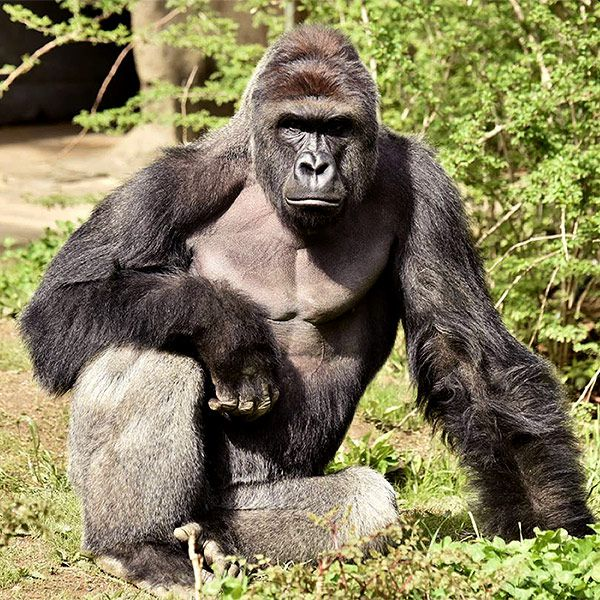

In [25]:
img_url = "https://people.com/thmb/JHST-eDLfLcDg3e1ARcw_Gd2grg=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc():focal(299x0:301x2)/cincinnati-zoo-600-1-74a2e732838b4806b56aade013097b2f.jpg"
img_request = requests.get(img_url)
gorilla_img = Image.open(BytesIO(img_request.content))

display(gorilla_img)

And let's process this image - or rather, crop it into a 224x224 square and normalise it.

In [15]:
image_inputs = processor(images=gorilla_img, return_tensors="pt")

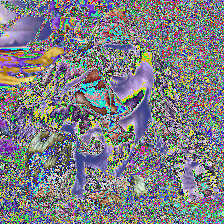

In [16]:
transform=T.ToPILImage()
img=transform(image_inputs.pixel_values[0])

img

You can clearly see some of the image details have been preserved and are still interpretable by us humans, such as his eyes, and parts of his chest, but for the most part it's been turned into uninterpretable noise!

In [17]:
image_inputs = image_inputs.to(torch_device).to(torch.float16) #casting to lower precision

Before we continue, let's take a quick look at the shape of the input data, and compare it to our original data

In [18]:
print(f"the original image is {gorilla_img.size}")
print(f"The processed image input is {image_inputs['pixel_values'].shape}")

the original image is (600, 600)
The processed image input is torch.Size([1, 3, 224, 224])


Now let's run the model:

In [19]:
embedding=image_model(**image_inputs)
embedding

CLIPVisionModelOutput(image_embeds=tensor([[-1.3622e+00, -2.0079e-01,  1.1509e-01, -6.6816e-01,  4.6106e-01,
          2.3273e-01, -3.3521e-02, -4.7983e-02, -8.1267e-02, -8.4693e-03,
          9.7285e-02,  2.8791e-01,  6.7215e-02, -3.3381e-01,  4.2922e-02,
          5.4903e-01, -5.8362e-03,  4.8550e-01,  9.3886e-01, -9.1207e-01,
          7.4210e-02,  1.0301e+00, -1.1212e+00, -1.0488e+00, -6.1090e-01,
          2.6361e-01, -5.5910e-01,  3.1900e-02,  6.1810e-01, -3.6691e-01,
          3.9601e-01,  1.9733e-01,  1.2982e-01,  1.1171e-01,  2.5133e-01,
         -2.2104e-01,  5.9576e-01,  2.7829e-01, -4.7128e-01, -3.8151e-01,
          5.7941e-02,  3.7470e-01, -5.6892e-01,  1.3009e-01,  1.5703e-01,
          5.4646e-01,  4.9338e-01, -6.3765e-01, -6.2831e-01, -1.9391e-01,
         -1.0490e-01, -6.8513e-02,  1.9337e-01,  6.5283e-01,  6.1097e-01,
         -1.0885e+00,  5.2397e-02, -2.6969e-01, -6.0201e-01,  4.3697e-01,
         -1.2060e-01,  2.5867e-01, -2.1872e-01, -2.6917e-01,  6.0160e-01,
   

In [20]:
print(f'The shape of the last hidden state is {embedding.last_hidden_state.shape}')
print(f'The shape of the pooled output is {embedding.image_embeds.shape}')

The shape of the last hidden state is torch.Size([1, 257, 1024])
The shape of the pooled output is torch.Size([1, 768])


What you'll notice here is similar to the text_encoder's output- we have a last_hidden_state output and a pooler_output. The first one is the "image_embed", which is shaped [1,768], like the text embedding from earlier, and the last_hidden_state is each individual "token"'s embedding (sort of like the 77 tokens we had earlier in the sentence embedder). One thing to note here is that, to reduce the dimensions of the image model's last hidden state from 1024 to 768, the OpenAI team used a [linear projection layer](https://www.geeksforgeeks.org/what-is-a-projection-layer-in-the-context-of-neural-networks/).

Below is an image embedding function that I've written for you to play with - just put in any image URL and you should be able to embed your image!

In [21]:
def image_embedder(img_url):
    img_request = requests.get(img_url)
    input_img = Image.open(BytesIO(img_request.content))
    image_inputs = processor(images=input_img, return_tensors="pt")
    image_inputs = image_inputs.to(torch_device).to(torch.HalfTensor)
    outputs = image_model(**image_inputs)
    img_embedding = outputs.image_embeds
    return img_embedding

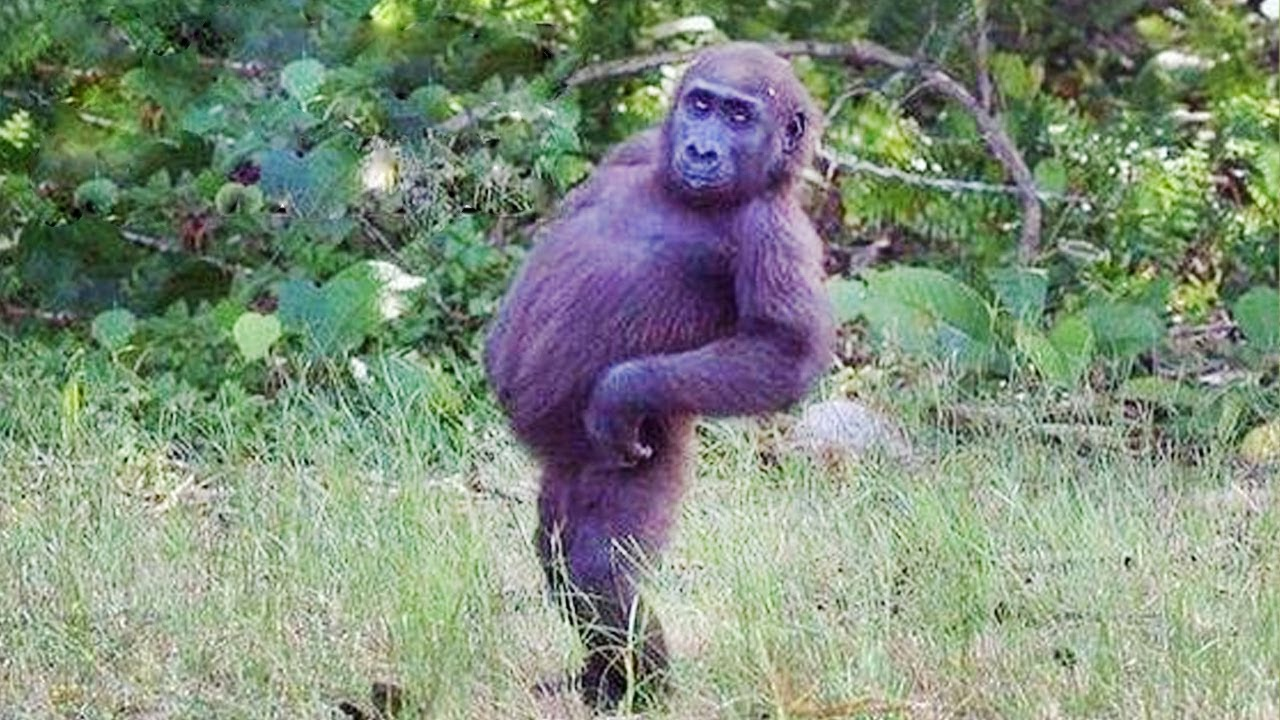

tensor([[-6.6355e-01, -1.1344e-01, -5.3989e-02, -2.9852e-02,  4.4818e-01,
          4.8052e-01,  2.8755e-01, -7.1532e-01, -3.2396e-01, -2.2088e-01,
          3.1875e-01,  2.5414e-01, -5.2564e-01, -1.9584e-01,  1.8240e-01,
         -5.4053e-01, -2.2639e-01,  2.0417e-01,  1.4578e-01, -1.7611e-01,
          1.1156e-01,  5.4360e-01, -3.7416e-01,  4.0361e-01, -1.4690e+00,
         -8.3186e-02,  2.5040e-02,  6.5465e-01,  1.4758e+00,  6.7463e-02,
         -3.9148e-01,  6.5342e-02,  2.2848e-01, -6.2099e-01,  6.8787e-01,
          4.1925e-01, -8.0380e-02,  1.8222e-02, -6.5424e-01, -2.9514e-01,
          7.4802e-01,  5.0231e-01, -6.6104e-01, -5.7540e-01,  6.7027e-01,
          1.9155e-01, -2.2358e-01, -4.5550e-01, -1.0817e-01, -1.0208e+00,
          5.3426e-02, -5.3459e-01,  4.0080e-02, -1.1664e-01, -3.6902e-01,
         -2.5339e-01, -7.7262e-03,  3.3289e-01, -3.3446e-01,  1.2238e-01,
          2.6516e-01, -4.4567e-02,  2.6894e-01,  6.4535e-01, -2.5919e-02,
         -5.3411e-01,  3.5221e-01,  1.

In [24]:
url='https://i.ytimg.com/vi/pcm5Tbcr_yo/maxresdefault.jpg'
request = requests.get(url)
img = Image.open(BytesIO(request.content))

display(img)
print(image_embedder(url))

Great! Now that that's done, we should be able to compare these to the text embeddings. 

#### Measuring the distance between text and image embeddings

We've got all of our components loaded, which will allow us to do what we've been talking about this whole time - compare text and image embeddings. But one final bit of knowledge before we crack on - how do we actually measure "distance" in this context?

If you're a Natural Language Processing (NLP) connoisseur, you'd be familiar with [Cosine Similarity](https://www.sciencedirect.com/topics/computer-science/cosine-similarity#:~:text=Cosine%20similarity%20measures%20the%20similarity,document%20similarity%20in%20text%20analysis.) as a distance metric - which is what is used in the CLiP model. For the uninitiated, this is a metric that measures the *angle* between two vectors in vector space, rather than our more intuitive, traditional understanding of distance (i.e. [Euclidean Distance](https://byjus.com/maths/euclidean-distance/), or being incredibly reductive, the pythagorean theorem generalised). Historically cosine similarity was favoured in NLP given that most approaches to tokenisation/embedding resulted in creating [sparse vectors](https://milvus.io/docs/sparse_vector.md) (vectors with lots of zero values), which meant that embeddings with lots of non-zero values would artificially be clumped close together purely because the vectors were "bigger", regardless of what the actual text was. Now, given more advanced modelling techniques that return [dense vectors](https://medium.com/@yasindusanjeewa8/dense-vectors-in-natural-language-processing-06818dff5cd7) (vectors with almost entirely non-zero values), this choice is mostly arbitrary, with several other metrics that can also be used in this space effectively (e.g. dot-product, euclidean distance, L1 distance). **In this case, however, the model was trained with cosine similarity as the distance metric, so we will use this at inference**.

Now, with that out of the way, let's import and define our distance metric:

In [132]:
from torch.nn import CosineSimilarity

cos_sim=CosineSimilarity()

Now let's run our text similarity analysis on our existing gorilla embedding, with this series of text prompts:

- an incredibly tasteful rendering of a walled garden
- the folly of man
- funny gorilla
- dog

We'll visualise our results in a plot as well

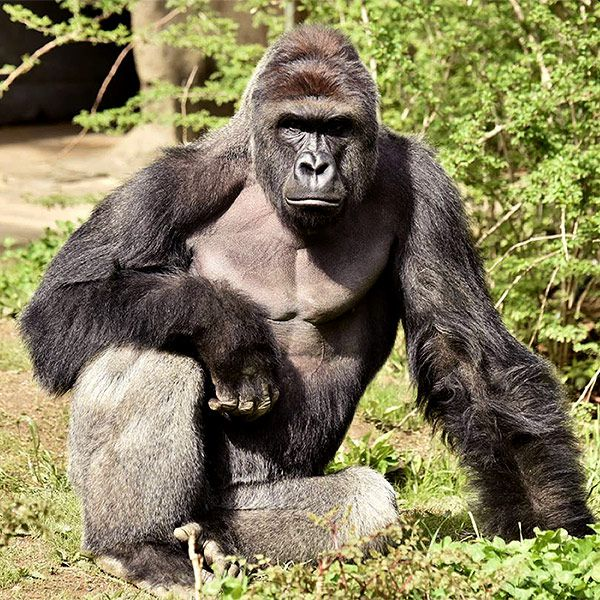

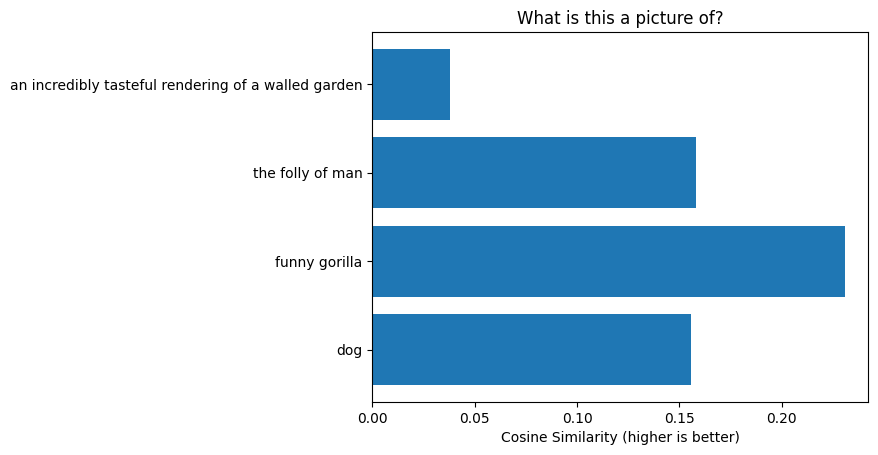

In [135]:
import matplotlib.pyplot as plt
import numpy as np


def CLIP(caption_candidates, img_URL):
    img_request = requests.get(img_URL)
    display_img = Image.open(BytesIO(img_request.content))

    
    img_embedding=image_embedder(img_URL).cpu().detach()
    
    caption_embeddings = sentence_embedder(caption_candidates).text_embeds.cpu().detach()
    
    output_cos_sims = cos_sim(img_embedding.cpu().detach(), caption_embeddings)
    
    output_cos_sims_lst = list(output_cos_sims)
    
    #create plots for distance
    fig, ax = plt.subplots()
    
    y_pos=np.arange(len(caption_candidates))
    
    ax.barh(y_pos, output_cos_sims_lst, align='center')
    ax.set_yticks(y_pos, labels=caption_candidates)
    ax.invert_yaxis()
    ax.set_xlabel('Cosine Similarity (higher is better)')
    ax.set_title('What is this a picture of?')
    
    display(display_img)
    plt.show()

CLIP(
    caption_candidates = ['an incredibly tasteful rendering of a walled garden', 'the folly of man', 'funny gorilla', 'dog'],
    img_URL = "https://people.com/thmb/JHST-eDLfLcDg3e1ARcw_Gd2grg=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc():focal(299x0:301x2)/cincinnati-zoo-600-1-74a2e732838b4806b56aade013097b2f.jpg"
)


Well look at that - the caption with the highest cosine similarity is the correct one - "funny gorilla"! Looks like it's working as intended. 

And that's the whole CLiP model explained! Feel free to play around with your own text and image inputs below:

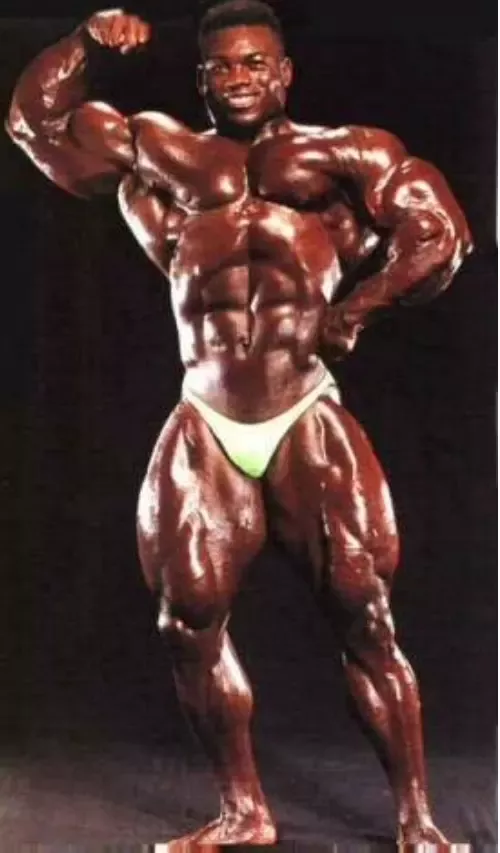

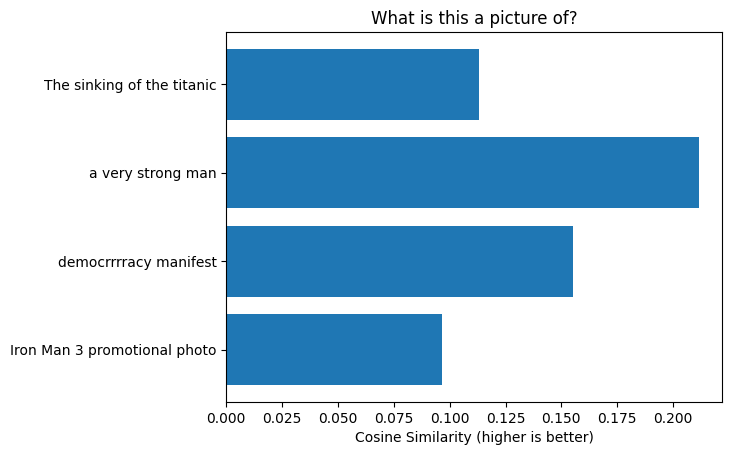

In [136]:
CLIP(
    caption_candidates = ['The sinking of the titanic', 'a very strong man', 'democrrrracy manifest', 'Iron Man 3 promotional photo'],
    img_URL = "https://qph.cf2.quoracdn.net/main-qimg-3235c2e300659c11539b50be46249825.webp"
)

##### Now that you understand how the CLiP model works, hopefully some intuitions can be gleaned as to why Stability.AI decided to use this as their text embedder for Stable Diffusion v1.4. As mentioned earlier, we'll be using the unpooled embeddings later in this series as the text embedding inputs into the Stable Diffusion model cascade :)

#### Let's move on to the AutoEncoder!